In [39]:
import csv
import datetime
import json
import logging
import openpyxl
import os
import requests
from time import sleep

# !pip install selenium
# !pip install jieba
# !pip install wordcloud
from bs4 import BeautifulSoup
from imageio import imread
import jieba
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from wordcloud import WordCloud, ImageColorGenerator

In [40]:
# request header
header = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_4) AppleWebKit/537.13 (KHTML, like Gecko) Chrome/24.0.1290.1 Safari/537.13',
    'Accept': 'text/html',
    'Cookie': "_uuid=1DBA4F96-2E63-8488-DC25-B8623EFF40E773841infoc; buvid3=FE0D3174-E871-4A3E-877C-A4ED86E20523155831infoc; LIVE_BUVID=AUTO8515670521735348; sid=l765gx48; DedeUserID=33717177; DedeUserID__ckMd5=be4de02fd64f0e56; SESSDATA=cf65a5e0%2C1569644183%2Cc4de7381; bili_jct=1e8cdbb5755b4ecd0346761a121650f5; CURRENT_FNVAL=16; stardustvideo=1; rpdid=|(umY))|ukl~0J'ulY~uJm)kJ; UM_distinctid=16ce0e51cf0abc-02da63c2df0b4b-5373e62-1fa400-16ce0e51cf18d8; stardustpgcv=0606; im_notify_type_33717177=0; finger=b3372c5f; CURRENT_QUALITY=112; bp_t_offset_33717177=300203628285382610"
}

# set up chrome options
chrome_options = Options()
chrome_options.add_argument("--window-size=1920x1080")
chrome_driver_path = r'/Users/haozaijie/Desktop/all/hackerank/webscrape/news_scrape/chromedriver.exe'
browser = webdriver.Chrome(options=chrome_options,
                          executable_path=chrome_driver_path)
WAIT = WebDriverWait(browser, 10)

# create logger
FORMAT = '%(asctime)s %(message)s'
logging.basicConfig(format=FORMAT)
logger = logging.getLogger(__name__)
logger.setLevel('INFO')

In [46]:
def search_page(uuid, pagenum):
    """Get metadata for all the videos for given page and user(uuid)."""
    logger.info(f'search videos on page {pagenum}')
    url = f'https://space.bilibili.com/{uuid}/video?tid=0&page={pagenum}'
    logger.info("request page")
    browser.get(url)
    mostClick = WAIT.until(EC.element_to_be_clickable((By.XPATH, r'//div[@class="be-tab"]')))
    mostClick.click()
    sleep(3)
    
    html = browser.page_source
    soup = BeautifulSoup(html, features="html5lib")
    ids = soup.find_all("div", class_= "title-row")
    logger.info(f'{len(ids)} videos in total')
    for id in ids:
        bvid_ls.append(id.find('a')['href'].split("/video/")[1])
        title_ls.append(id.find('a')['title'])

    metas = soup.find_all('div', class_='meta clearfix')
    for meta in metas:
        play_ls.append( meta.find('span', class_='play').text.strip())
        comment_ls.append( meta.find('span', class_='comments').text.strip())
        
        # add back current year to time
        video_date = meta.find('span', class_='time').text.strip()
        if len(video_date.split('-')) ==3:
            time_ls.append(video_date)
        else:
            time_ls.append(str(datetime.datetime.now().year) + '-' + video_date)


    temp_meta_df = pd.DataFrame({'bvid':bvid_ls, 'title':title_ls, 'play': play_ls,
                                'comment': comment_ls, 'date': time_ls})
    
    temp_meta_df.drop_duplicates(inplace=True)
    
    return temp_meta_df


def get_meta_df(uuid, max_pagenum):
    """Create dataframe with meta data for videos on all pages for given user."""
    pagenum =1 
    meta_df = pd.DataFrame()
    
    logger.info('start danmaku scraper')
    while pagenum <= max_pagenum:
        temp_meta_df = search_page(uuid, pagenum)
        meta_df = meta_df.append(temp_meta_df)
        pagenum += 1
    meta_df.drop_duplicates(inplace=True)
    return meta_df


def get_cid(bvid):
    """Each video has bvid and cid. Use API to get cid for given bvid."""
    sleep(5)
    logger.info(f'get cid for bvid {bvid}')
    api_url = f'https://api.bilibili.com/x/player/pagelist?bvid={bvid}'
    
    r = requests.get(api_url, headers=header)
    if r.status_code==200:
        return r.json().get('data')[0].get('cid')
    else:
        logger.info(f'cannot get cid for bvid {bvid}')
        return None 


def get_current_danmaku(cid):
    """Get current danmaku for given cid."""
    sleep(5)
    logger.info('get current danmaku')
    cid_url = f"http://comment.bilibili.com/{cid}.xml" 
    
    r = requests.get(cid_url, headers=header)
    if r.status_code == 200:
        html = r.content
        html_doc = str(html, 'utf-8')
        soup = BeautifulSoup(html_doc, 'html.parser')
        
#         # only get 4th and 7th data point of p tag
#         data = [[i.get('p').split(',')[4], i.get('p').split(',')[7], i.text] for i in soup.find_all('d')]
#         col_names= ['timestamp','uniqueid','danmaku']
        
        # get all data points of p tag
        data = [i.get('p').split(',') +  [i.text] for i in soup.find_all('d')]
        col_names=['dtTime', 'danmu_model', 'font', 'rgb', 'timestamp','danmu_chi', 'userID', 'rowID', 'danmaku']
        
        df = pd.DataFrame(data, columns=col_names)
        df['timestamp'] = df['timestamp'].astype('int')
    else:
        df= pd.DataFrame()
        
    logger.info(f"there are {len(df)} danmaku")
    
    return df


def get_per_day_danmaku(cid, date):
    """Get historical danmaku for given cid and date."""
    cid_url_h = f'https://api.bilibili.com/x/v2/dm/history?type=1&date={str(date)[:10]}&oid={cid}'
    r = browser.get(cid_url_h)
    html = browser.find_element_by_tag_name('i').get_attribute('innerHTML')
    soup = BeautifulSoup(html, features='html5lib')
    
#     # only get 4th and 7th data point of p tag
#     data = [[i.get('p').split(',')[4], i.get('p').split(',')[7], i.text] for i in soup.find_all('d')]
#     col_names= ['timestamp','uniqueid','danmaku']
    
    # get all data points of p tag
    data = [i.get('p').split(',') +  [i.text] for i in soup.find_all('d')]
    col_names=['dtTime', 'danmu_model', 'font', 'rgb', 'timestamp','danmu_chi', 'userID', 'rowID', 'danmaku']
    df = pd.DataFrame(data, columns=col_names)
    df['timestamp'] = df['timestamp'].astype('int')
    return df


def get_historical_danmaku(cid, start_date, end_date = datetime.date.today()):
    """Get all historical danmaku for given cid since the video was posted."""
    sleep(2)
    date_range = pd.date_range(pd.to_datetime(start_date), pd.to_datetime(end_date))
    hist_df = pd.DataFrame()
    
    for date in date_range:
        try:
            logger.info(f'get historical danmaku for {str(date)[:10]}')
            sleep(5)
            day_df = get_per_day_danmaku(cid, date)
            logger.info(f'there are {len(day_df)} danmaku')
            hist_df = hist_df.append(day_df)
        except:
            pass
    
    return hist_df


def get_final_df(meta_df):
    """Get all current and historical danmaku for all the videos in meta_df."""
    final_df = pd.DataFrame()
    for n in range(len(meta_df)):
        bvid = meta_df['bvid'][n]
        start_date = meta_df['date'][n]
        cid = get_cid(bvid)
        try:
            df_current = get_current_danmaku(cid)
            df_current['bvid'] = bvid
            final_df = final_df.append(df_current)
            final_df.drop_duplicates(inplace=True)
        except Exception as e:
            logger.info(e)
            pass

        try:
            df_historical = get_historical_danmaku(cid, start_date)
            df_historical['bvid'] = bvid
            final_df = final_df.append(df_historical)
            final_df.drop_duplicates(inplace=True)
        except Exception as e:
            logger.info(e)
            pass
    
    return final_df


def clean_final_df(final_df, meta_df):
    """Merge the meta data to the danmaku dataframe."""
    final_df.drop_duplicates(inplace=True)
    final_df = final_df.merge(meta_df, on='bvid')
    final_df['date'] = [i for i in final_df['timestamp'].apply(datetime.datetime.fromtimestamp)]
    logger.info(final_df.groupby('bvid')['danmaku'].count())
    return final_df


def clean_danmaku(ls):
    """Tokenize danmaku and remove stopwords. Returns a list."""
    danmaku_ls = []
    # get stopwords
    with open(os.path.join(os.getcwd(), 'cn_stopwords.txt'), 'r') as f:
        stopwords = f.read().splitlines() 
    
    # use jieba to cut danmaku and remove stopwords
    for phrase in ls:
        seg_list = jieba.cut(phrase, cut_all=False)
        for i in seg_list:
            if i not in stopwords:
                danmaku_ls.append(i)
    return danmaku_ls


def create_wordcloud(danmaku_ls, image_name):
    """Generate wordcloud using the clean danmaku list and save it to current folder."""
    back_coloring = imread(os.path.join(os.getcwd(), "background.jpg"))
    wc = WordCloud(background_color='white',  
               max_words=500,  
               mask=back_coloring,  
               color_func = ImageColorGenerator(back_coloring), 
               max_font_size=100,  
               font_path=os.path.join(os.getcwd(),'MaShanZheng.ttf'),  #provide Chinese font, otherwise cannot display
               random_state=42,  
               width=1000,  
               height=860  
               )
    wc.generate(' '.join(danmaku_ls))
    plt.imshow(wc)
    plt.axis("off")
    plt.show()
    wc.to_file(os.path.join(os.getcwd(), f"{image_name}.jpg"))

    
def main(uuid, pagenum, image_name):
    global bvid_ls, title_ls, play_ls, comment_ls, time_ls
    bvid_ls, title_ls, play_ls, comment_ls, time_ls = ([],[],[],[],[])
         
    # get meta data for each video in the given pages
    meta_df = get_meta_df(uuid, pagenum)
    print(meta_df.head(5))
    
    #log in to get historical danmaku
    log_url = 'https://passport.bilibili.com/login'
    browser.get(log_url)
    input('log in to bilibili and press enter to continue :')
    
    # get danmaku for each video
    final_df = get_final_df(meta_df)
    
    # clean danmaku and get word count
    final_df = clean_final_df(final_df, meta_df)
    
    # create wordcloud
    danmaku_ls = clean_danmaku(list(final_df['danmaku']))
    create_wordcloud(danmaku_ls, image_name)
    
    return final_df

2020-08-15 00:11:58,178 start danmaku scraper
2020-08-15 00:11:58,181 search videos on page 1
2020-08-15 00:11:58,183 request page
2020-08-15 00:12:03,386 7 videos in total


           bvid                                              title   play  \
0  BV1Fk4y1B798                          大家好，我是音乐剧演员阿云嘎，今天正式入驻B站啦！  37.9万   
1  BV1pt4y1X78P                        清唱一剪梅！阿云嘎不得不聊的“名场面”【UP！大明星】  31.2万   
2  BV15i4y1V71o                        【阿云嘎】嘎言嘎语超刺激reaction？我要退b站！  28.7万   
3  BV1gV411r7on  【阿云嘎】新歌都听了吗？今日送上”优秀”的打样视频！我飘了，决定向up主发起挑战，带话题#阿...  15.1万   
4  BV1ra4y1a7y9                 【阿云嘎】新专3天后上，而我正吹着海风信心满满，用行动说明没在怕的！   6.7万   

  comment       date  
0      1万  2020-7-12  
1    1.2万  2020-7-20  
2    7950  2020-7-16  
3    6055  2020-7-24  
4    1364  2020-7-20  
log in to bilibili and press enter to continue :


2020-08-15 00:12:14,312 get cid for bvid BV1Fk4y1B798
2020-08-15 00:12:19,792 get current danmaku
2020-08-15 00:12:20,452 there are 500 danmaku
2020-08-15 00:12:22,466 get historical danmaku for 2020-07-12
2020-08-15 00:12:28,255 there are 500 danmaku
2020-08-15 00:12:28,257 get historical danmaku for 2020-07-13
2020-08-15 00:12:34,134 there are 500 danmaku
2020-08-15 00:12:34,137 get historical danmaku for 2020-07-14
2020-08-15 00:12:40,313 there are 500 danmaku
2020-08-15 00:12:40,317 get historical danmaku for 2020-07-15
2020-08-15 00:12:46,182 there are 500 danmaku
2020-08-15 00:12:46,185 get historical danmaku for 2020-07-16
2020-08-15 00:12:51,951 there are 500 danmaku
2020-08-15 00:12:51,956 get historical danmaku for 2020-07-17
2020-08-15 00:12:57,748 there are 500 danmaku
2020-08-15 00:12:57,753 get historical danmaku for 2020-07-18
2020-08-15 00:13:03,807 there are 500 danmaku
2020-08-15 00:13:03,821 get historical danmaku for 2020-07-19
2020-08-15 00:13:09,608 there are 500 

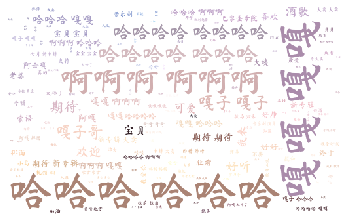

In [47]:
df = main(613391326, 1, "ayunga_bilibili_wordcloud")

In [49]:
danmaku_ls = clean_danmaku(list(df['danmaku']))

In [61]:
sorted_freq_dict = {k: v for k, v in sorted(freq_dict.items(), key=lambda item: item[1], reverse=True)}

In [104]:
def create_wordcloud(danmaku_ls, image_name):
    
    """Generate wordcloud using the clean danmaku list and save it to current folder."""
    freq_dict={}
    for danmaku in danmaku_ls:
        if danmaku not in freq_dict:
            freq_dict[danmaku] = 1
        else:
            freq_dict[danmaku] += 1
    
    background = imread(os.path.join(os.getcwd(), "background.jpg"))
    wc = WordCloud(background_color='white',  
               max_words=50,  
               mask=back_coloring,  
               color_func = ImageColorGenerator(back_coloring), 
               max_font_size=200,  
               font_path=os.path.join(os.getcwd(),'MaShanZheng.ttf'),  #provide Chinese font, otherwise cannot display
               random_state=42,  
               width=1000,  
               height=860  
               )
    wc.generate_from_frequencies(freq_dict)
    plt.imshow(wc)
    plt.axis("off")
    plt.show()
    wc.to_file(os.path.join(os.getcwd(), f"{image_name}.jpg"))

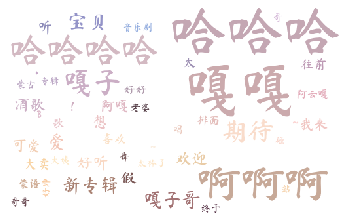

In [105]:
create_wordcloud(freq_dict, 'ayunga_bilibili_wordcloud')

In [ ]:
df.groupby('bvid')['danmaku'].count()

In [ ]:
df.drop_duplicates().groupby('bvid')['danmaku'].count()

In [ ]:
# final_df.drop_duplicates(inplace=True)

In [ ]:
# final_df.to_csv('ayunga.csv')

In [ ]:
# final_df.head()